### [Merlion for Time Series Forecasting](https://medium.com/@kylejones_47003/merlion-for-time-series-forecasting-with-python-8bc2bb747aeb)

**Merlion** is an open-source Python library designed for time series forecasting and anomaly detection. Developed by **Salesforce**, it simplifies the end-to-end workflow of time series analysis by integrating data preprocessing, model training, evaluation, and visualization into a single framework.

**Merlion** supports statistical models, machine learning approaches, and deep learning models. Merlion requires time series data in Pandas DataFrame format with timestamps.

- Merlion provides several forecasting models, including ARIMA and Prophet.

- Merlion simplifies benchmarking multiple models.

- Merlion has several features for measuring forecast accuracy like _sMAPE (symetric mean absolute percentage error)_.

- Merlion supports both supervised and unsupervised anomaly detection models.

- Merlion simplifies time series forecasting and anomaly detection in Python with built-in evaluation and visualization tools.

In [1]:
!pip install -q numpy pandas matplotlib
!pip install -q scipy scikit-learn salesforce-merlion

In [2]:
import warnings
warnings.filterwarnings('ignore')

21:50:42 - cmdstanpy - INFO - Chain [1] start processing


No transform...


21:50:42 - cmdstanpy - INFO - Chain [1] done processing


No Transform - sMAPE: 25.12


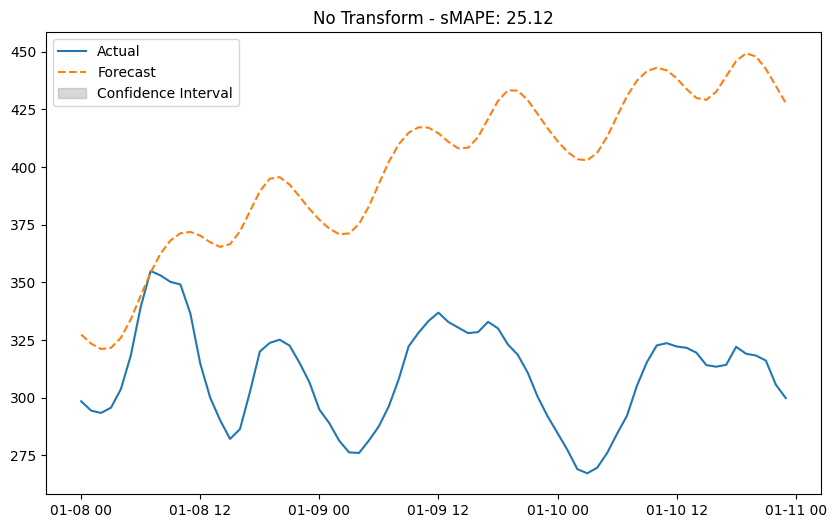

Inferred granularity <Hour>
21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing


Normalize...
Mean-Variance Normalize - sMAPE: 20.22


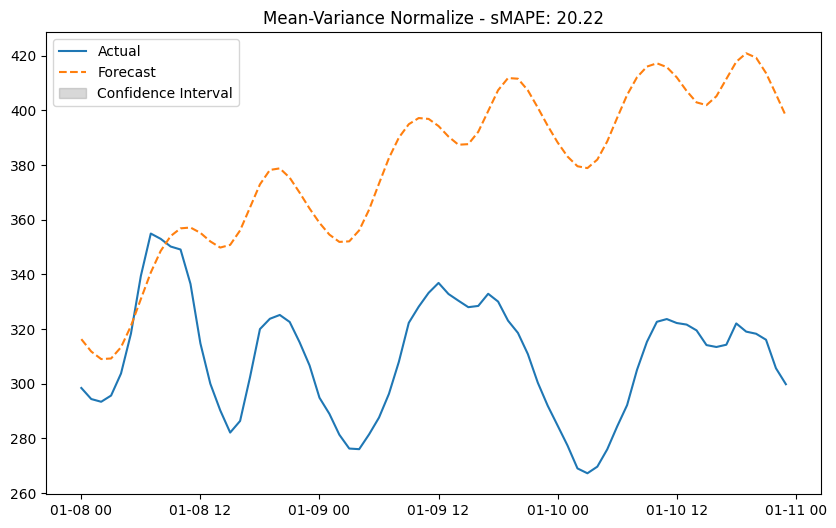

Inferred granularity <Hour>
21:50:43 - cmdstanpy - INFO - Chain [1] start processing


Moving Average...


21:50:43 - cmdstanpy - INFO - Chain [1] done processing


Moving Average Transform - sMAPE: 29.26


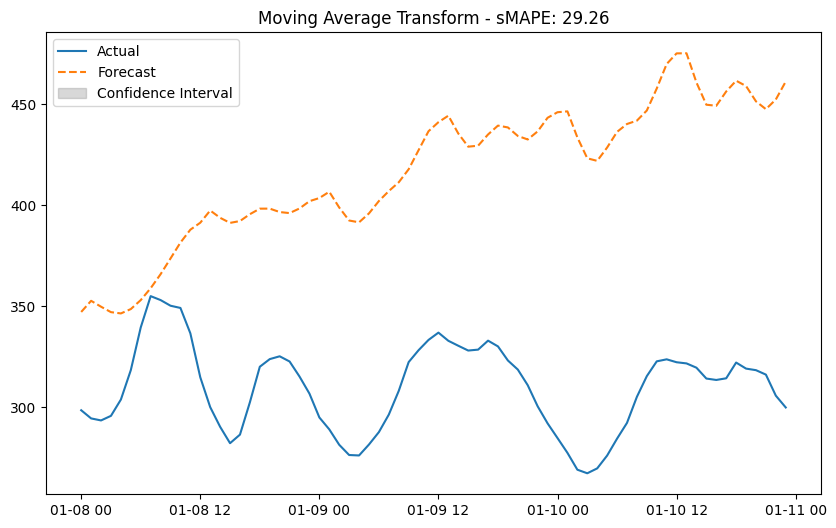

Seasonal Differencing...


Inferred granularity <Hour>
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing


Seasonal Differencing Transform - sMAPE: 49.70


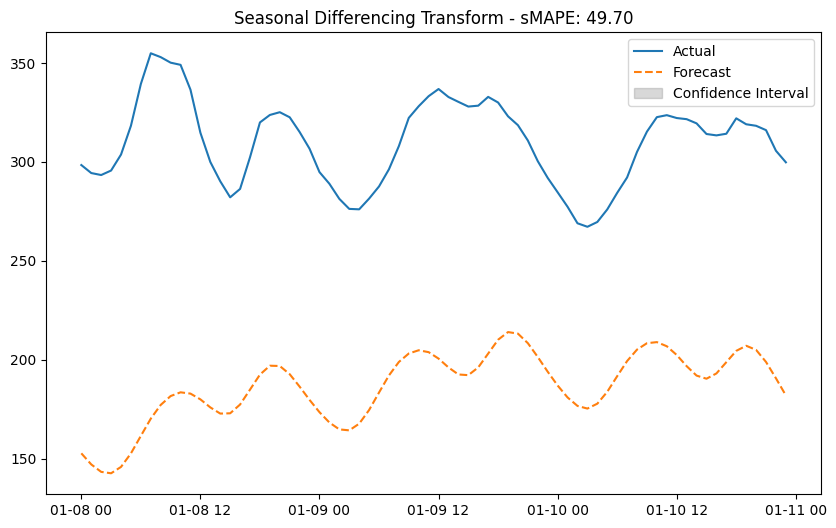

Inferred granularity <Hour>



=== ARIMA Model ===
Merlion ARIMA - sMAPE: 6.04


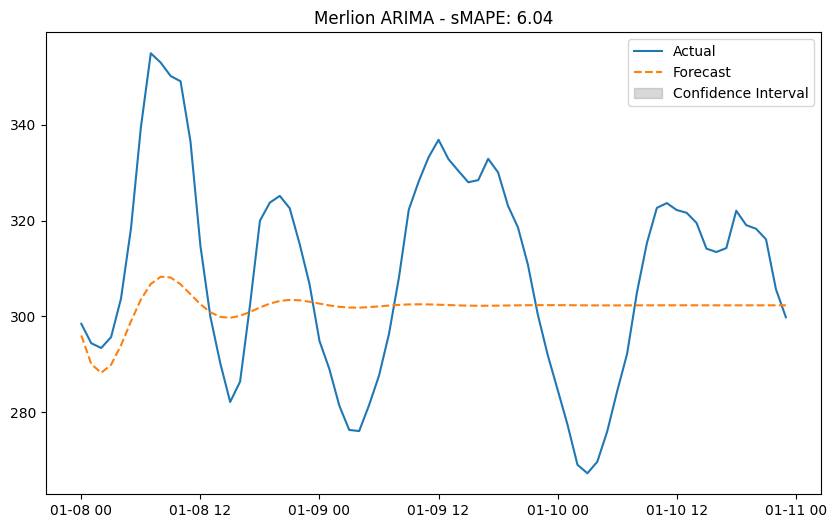

Inferred granularity <Hour>



=== Default Forecaster (Baseline Model) ===
Default Forecaster - sMAPE: 4.69


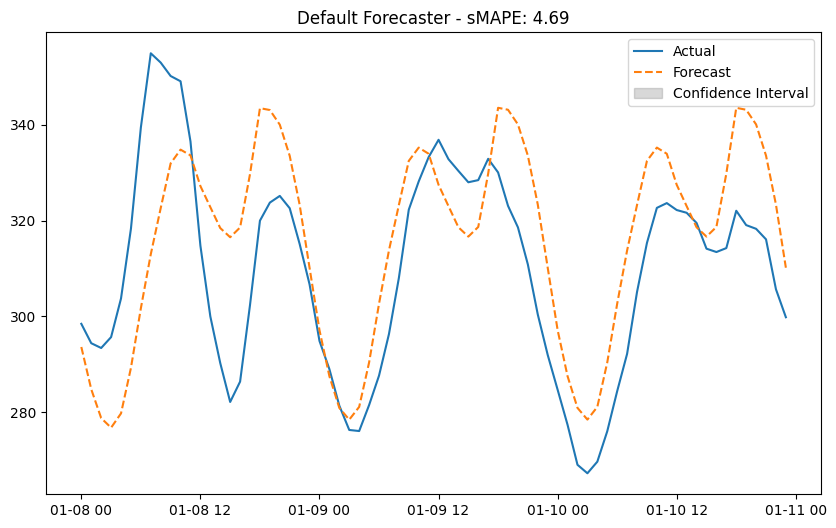

                                Model      sMAPE
5                  Default Forecaster   4.687027
4                       Merlion ARIMA   6.038623
1   Prophet (Mean-Variance Normalize)  20.219945
0              Prophet (No Transform)  25.115221
2  Prophet (Moving Average Transform)  29.261788
3     Prophet (Seasonal Differencing)  49.695790


In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.factory import ModelFactory
from merlion.models.forecast.prophet import ProphetConfig
from merlion.models.forecast.arima import ArimaConfig
from merlion.models.defaults import DefaultForecasterConfig
from merlion.transform.resample import TemporalResample
from merlion.transform.sequence import TransformSequence
from merlion.utils import TimeSeries
from merlion.transform.normalize import MeanVarNormalize
from merlion.transform.moving_average import MovingAverage, DifferenceTransform
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from scipy.stats import norm

# Load ERCOT dataset with hourly resampling and outlier removal
url = "https://raw.githubusercontent.com/kylejones200/time_series/main/ercot_load_data.csv"
df = pd.read_csv(url)

# Convert time column to datetime format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Resample to hourly frequency
df = df.resample('H').mean()
df['values'] = df['values'].interpolate()

# Remove outliers (values beyond 3 standard deviations)
df["z_score"] = (df["values"] - df["values"].mean()) / df["values"].std()
df = df[df["z_score"].abs() < 3]
df.drop(columns=["z_score"], inplace=True)

# Convert to Merlion TimeSeries format
ts = TimeSeries.from_pd(df)

# Optimize Data Splitting using TimeSeriesSplit (Cross-validation)
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(df))[-1]  # Use the last split
train_data = TimeSeries.from_pd(df.iloc[train_idx])
test_data = TimeSeries.from_pd(df.iloc[test_idx])

# Function to create a model using ModelFactory
from merlion.models.factory import ModelFactory

def get_model(model_type="prophet", transform=None):
    config_dict = {
        "prophet": ProphetConfig(
            add_seasonality="auto",
            weekly_seasonality=True,
            daily_seasonality=True,
            changepoint_prior_scale=0.05,  # Better trend detection
            transform=TransformSequence([TemporalResample(), transform]) if transform else None
        ),
        "arima": ArimaConfig(order=(2, 1, 2), target_seq_index=0),
        "default": DefaultForecasterConfig()
    }

    model_mapping = {
        "prophet": "merlion.models.forecast.prophet:Prophet",
        "arima": "merlion.models.forecast.arima:Arima",
        "default": "merlion.models.defaults:DefaultForecaster"
    }

    if model_type not in model_mapping:
        raise ValueError(f"Invalid model type: {model_type}")

    return ModelFactory.create(model_mapping[model_type], **config_dict[model_type].to_dict())


# Function to evaluate and visualize forecasts
def eval_model(model, train_data, test_data, title):
    forecast_horizon = min(len(test_data), 168)  # Forecast up to 7 days (168 hours)
    t = test_data.time_stamps[:forecast_horizon]

    model.train(train_data)
    yhat_test, test_err = model.forecast(t)

    smape_value = ForecastMetric.sMAPE.value(test_data, yhat_test)

    # Confidence Intervals
    if hasattr(model, "forecast") and test_err is not None:
        ci_multiplier = 1.96  # 95% confidence
        lb = (yhat_test.to_pd() - ci_multiplier * test_err.to_pd().abs()).values.flatten()
        ub = (yhat_test.to_pd() + ci_multiplier * test_err.to_pd().abs()).values.flatten()

        # Ensure confidence intervals have the same length as timestamps
        min_length = min(len(t), len(lb), len(ub))
        t = t[:min_length]
        lb = lb[:min_length]
        ub = ub[:min_length]

    print(f"{title} - sMAPE: {smape_value:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(test_data.to_pd(), label="Actual")
    plt.plot(yhat_test.to_pd(), label="Forecast", linestyle="--")

    if hasattr(model, "forecast") and test_err is not None:
        plt.fill_between(t, lb, ub, color="gray", alpha=0.3, label="Confidence Interval")

    plt.legend()
    plt.title(f"{title} - sMAPE: {smape_value:.2f}")
    plt.show()

    return yhat_test

# Run Prophet Model Without Transformations
print("No transform...")
base = eval_model(get_model("prophet"), train_data, test_data, title="No Transform")

# Apply Normalization
print("Normalize...")
norm = eval_model(get_model("prophet", MeanVarNormalize()), train_data, test_data, title="Mean-Variance Normalize")

# Apply Moving Average Transform
print("Moving Average...")
ma = eval_model(get_model("prophet", MovingAverage(n_steps=12)), train_data, test_data, title="Moving Average Transform")

# Apply Seasonal Differencing
print("Seasonal Differencing...")
diff = eval_model(get_model("prophet", DifferenceTransform()), train_data, test_data, title="Seasonal Differencing Transform")

# Run Merlion ARIMA Model
print("\n=== ARIMA Model ===")
arima_results = eval_model(get_model("arima"), train_data, test_data, title="Merlion ARIMA")

# Run Default Forecaster (Baseline Model)
print("\n=== Default Forecaster (Baseline Model) ===")
default_results = eval_model(get_model("default"), train_data, test_data, title="Default Forecaster")

# Create a table of sMAPE values
smape_values = {
    "Prophet (No Transform)": ForecastMetric.sMAPE.value(test_data, base),
    "Prophet (Mean-Variance Normalize)": ForecastMetric.sMAPE.value(test_data, norm),
    "Prophet (Moving Average Transform)": ForecastMetric.sMAPE.value(test_data, ma),
    "Prophet (Seasonal Differencing)": ForecastMetric.sMAPE.value(test_data, diff),
    "Merlion ARIMA": ForecastMetric.sMAPE.value(test_data, arima_results),
    "Default Forecaster": ForecastMetric.sMAPE.value(test_data, default_results),
}

# Convert to a DataFrame
smape_table = pd.DataFrame(list(smape_values.items()), columns=["Model", "sMAPE"]).sort_values(by="sMAPE")
print(smape_table)

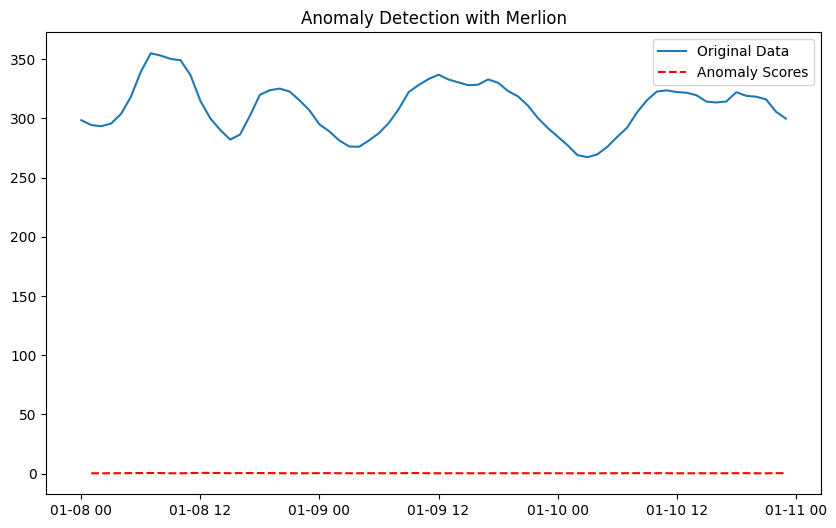

In [4]:
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig

# Initialize an Isolation Forest model with the correct config
config = IsolationForestConfig()
anomaly_model = IsolationForest(config)

# Train the model on the dataset
anomaly_model.train(train_data)

# Generate anomaly scores
anomalies = anomaly_model.get_anomaly_label(test_data)
scores = anomaly_model.get_anomaly_score(test_data)

# Plot anomaly scores
plt.figure(figsize=(10, 6))
plt.plot(test_data.to_pd(), label="Original Data")
plt.plot(scores.to_pd(), label="Anomaly Scores", color="red", linestyle="--")
plt.legend()
plt.title("Anomaly Detection with Merlion")
plt.show()